In [1]:
from datasets import load_dataset
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from collections import Counter
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.style.use("seaborn-whitegrid")

In [3]:
RANDOM_SEED = 1234
SPLITS = 5

In [4]:
np.random.seed(RANDOM_SEED)

In [5]:
sst_dataset = load_dataset("trec")

Found cached dataset trec (/home/studio-lab-user/.cache/huggingface/datasets/trec/default/2.0.0/f2469cab1b5fceec7249fda55360dfdbd92a7a5b545e91ea0f78ad108ffac1c2)


  0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
sst_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'coarse_label', 'fine_label'],
        num_rows: 5452
    })
    test: Dataset({
        features: ['text', 'coarse_label', 'fine_label'],
        num_rows: 500
    })
})

In [7]:
sst_dataset["train"]["text"][0:2]

['How did serfdom develop in and then leave Russia ?',
 'What films featured the character Popeye Doyle ?']

In [8]:
sst = pd.DataFrame()
sst["text"] = sst_dataset["train"]["text"]
sst["label"] = sst_dataset["train"]["coarse_label"]

In [9]:
sst.label.value_counts(normalize=True) * 100

1    22.927366
3    22.432135
2    21.313280
5    16.434336
4    15.315481
0     1.577403
Name: label, dtype: float64

In [10]:
def get_dict_size(text):
    vec = TfidfVectorizer(lowercase=True, ngram_range=(1,1), analyzer="word").fit(text)
    DICT_SIZE = len(vec.get_feature_names_out())
    return DICT_SIZE

In [11]:
DICT_SIZE = get_dict_size(sst["text"])
print(DICT_SIZE)

8410


In [12]:
pl = make_pipeline(TfidfVectorizer(max_features=int(DICT_SIZE * 0.9), lowercase=True, ngram_range=(1,1), analyzer="word"),
                   LogisticRegression(C=0.5, class_weight="balanced", random_state=RANDOM_SEED, max_iter=250)
                  )

In [13]:
pl.fit(sst["text"], sst["label"])

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(max_features=7569)),
                ('logisticregression',
                 LogisticRegression(C=0.5, class_weight='balanced',
                                    max_iter=250, random_state=1234))])

In [14]:
pl.score(sst["text"], sst["label"])

0.9015040352164343

In [15]:
cv = StratifiedKFold(n_splits=SPLITS)
cross_validate(pl, sst["text"], sst["label"], cv=cv, scoring={"accuracy", "f1_weighted"})

{'fit_time': array([1.65933156, 1.94050407, 1.41961026, 1.27710867, 1.38677239]),
 'score_time': array([0.0478425 , 0.04724264, 0.02353072, 0.02934408, 0.02381229]),
 'test_accuracy': array([0.78735105, 0.76901925, 0.77247706, 0.7733945 , 0.76513761]),
 'test_f1_weighted': array([0.79095564, 0.77593366, 0.77479202, 0.77640444, 0.76662912])}

In [16]:
acc_scores = []
f1_scores = []
fold = []
lab_perc = []
i_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
t0  = time.time()
for i in i_range:
    sst["ss_label"] = np.where(sst.index.isin(sst.sample(frac=1-i).index), -1, sst.label)
    ss_pl = make_pipeline(TfidfVectorizer(max_features=int(DICT_SIZE * 0.9), lowercase=True, ngram_range=(1,1), analyzer="word"),
                          SelfTrainingClassifier(
                          LogisticRegression(C=0.5, class_weight="balanced", random_state=RANDOM_SEED, max_iter=250)))
    
    for f, (train, test), in zip(range(SPLITS), cv.split(sst["text"], sst["label"])):
        ss_pl.fit(sst["text"][train], sst["ss_label"][train])
        ss_pl_preds = ss_pl.predict(sst["text"][test])
        acc_scores.append(accuracy_score(sst["label"][test], ss_pl_preds))
        f1_scores.append(f1_score(sst["label"][test], ss_pl_preds, average="weighted"))
        fold.append(f)
        lab_perc.append(i)

t1 = time.time()
exec_time = t1-t0
print(f"Execution time: {exec_time/60:.3f} minutes")

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/semi_supervised/_s

Execution time: 3.536 minutes


In [17]:
dataset_report = pd.DataFrame({"acc_scores": acc_scores,
                               "f1_scores": f1_scores,
                               "fold_number": fold,
                               "dataset_name": ["TREC_Train"] * len(acc_scores),
                               "classes": [sst["label"].nunique()] * len(acc_scores),
                               "dataset_len": [sst.shape[0]] * len(acc_scores),
                               "percent_labeled_samples": lab_perc,
                                "exec_time_secs_9_runs": [exec_time] * len(acc_scores)})

In [18]:
dataset_report

,acc_scores,f1_scores,fold_number,dataset_name,classes,dataset_len,percent_labeled_samples,exec_time_secs_9_runs
0,0.669111,0.675669,0,TREC_Train,6,5452,0.1,212.144848
1,0.643446,0.651978,1,TREC_Train,6,5452,0.1,212.144848
2,0.608257,0.617853,2,TREC_Train,6,5452,0.1,212.144848
3,0.669725,0.675379,3,TREC_Train,6,5452,0.1,212.144848
4,0.656881,0.661842,4,TREC_Train,6,5452,0.1,212.144848
5,0.727773,0.733004,0,TREC_Train,6,5452,0.2,212.144848
6,0.697525,0.704194,1,TREC_Train,6,5452,0.2,212.144848
7,0.692661,0.697694,2,TREC_Train,6,5452,0.2,212.144848
8,0.699083,0.703044,3,TREC_Train,6,5452,0.2,212.144848
9,0.684404,0.688891,4,TREC_Train,6,5452,0.2,212.144848


<AxesSubplot:xlabel='percent_labeled_samples', ylabel='acc_scores'>

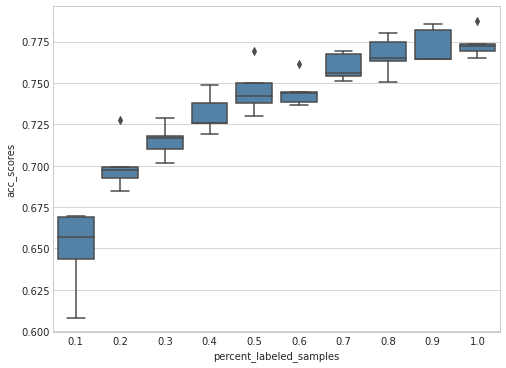

In [19]:
plt.figure(figsize=(8,6))
sns.boxplot(data=dataset_report, x="percent_labeled_samples", y="acc_scores", color="steelblue")

In [20]:
dataset_report.to_csv("trec.csv", index_label=False)

In [21]:
# fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12,6))
# ax[0].scatter(i_range, acc_scores)
# ax[0].plot(i_range, acc_scores)
# ax[0].set_xlabel("Percent of Labeled Samples")
# ax[0].set_ylabel("Accuracy Score")
# ax[0].set_title("% of Labeled Samples Vs Accuracy Score", fontweight="bold")
# ax[1].scatter(i_range, f1_scores)
# ax[1].plot(i_range, f1_scores)
# ax[1].set_xlabel("Percent of Labeled Samples")
# ax[1].set_ylabel("F1 Score")
# ax[1].set_title("% of Labeled Samples Vs F1 Score", fontweight="bold")
# plt.show()